<a href="https://colab.research.google.com/github/Frorozcoloa/FinancIA/blob/main/Notebooks/0-2%20Train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers wandb torchmetrics lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import wandb
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import set_seed
from torch import nn

def SEED(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    set_seed(seed)


SEED(42)


# Configuration by model
NUM_VARAIBLES = 3
NUM_LABELS = 3
num_labels = NUM_LABELS * NUM_VARAIBLES
divice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
from transformers import ( 
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_constant_schedule_with_warmup,
)

# Configuring the model
num_labels = NUM_LABELS * NUM_VARAIBLES
model_name = "pysentimiento/robertuito-sentiment-analysis"
auto_tokenizer = AutoTokenizer.from_pretrained(model_name)
model_hugginface = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, ignore_mismatched_sizes=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
a = auto_tokenizer("hola", return_tensors="pt" )
a

{'input_ids': tensor([[   0, 1878,    2]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

In [57]:
model_hugginface(a["input_ids"], a["attention_mask"], a["token_type_ids"]).logits

tensor([[-0.0108, -0.5057, -0.2136, -0.0062,  0.1209,  0.5468, -0.0044, -0.4294,
         -0.1055]], grad_fn=<AddmmBackward0>)

In [50]:
class FinanciaSentimental(Dataset):
    """This class is used to load the data and tokenize it"""
    def __init__(self, tokenizer, dataframe, columns, max_len=512):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        ## Columns to target
        self._columns = columns
        self.max_len = max_len
    
    @property
    def columns(self):
        """Return the columns to target"""
        return self._columns

    def __len__(self):
        """Return the length of the dataset"""
        return len(self.dataframe)
        
    def __getitem__(self, index):
        """Get the data at the index"""
        values = self.dataframe.iloc[index]
        text = values['text']
        label = values[self._columns].values.astype(np.float32)
        inputs = self.tokenizer.encode_plus(text, max_length=130, pad_to_max_length=True, padding='max_length', truncation=True, return_tensors='pt')
        label = torch.tensor(label, dtype=torch.float)
        input_ids = inputs["input_ids"].squeeze().to(dtype=torch.long)
        attention_mask = inputs["attention_mask"].squeeze().to(dtype=torch.long)
        token_type_ids = inputs["token_type_ids"].squeeze().to(dtype=torch.long)
        
        inputs_dict = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids,
            "labels":label
        }

        return inputs_dict

In [68]:
import torch
import lightning.pytorch as pl
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from torch.nn import BCEWithLogitsLoss

class FinanciaMultilabel(pl.LightningModule):
    
    def __init__(self, model, num_labels):
        super().__init__()
        self.model = model
        self.num_labels = num_labels
        self.loss = BCEWithLogitsLoss()
        self.validation_step_outputs = []

    def forward(self, input_ids, attention_mask, token_type_ids):
        return self.model(input_ids, attention_mask, token_type_ids).logits

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        token_type_ids = batch["token_type_ids"]
        outputs = self(input_ids, attention_mask, token_type_ids)
        loss = self.loss(outputs.view(-1,self.num_labels), labels.type_as(outputs).view(-1,self.num_labels))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        token_type_ids = batch["token_type_ids"]
        outputs = self(input_ids, attention_mask, token_type_ids)
        loss = self.loss(outputs.view(-1,self.num_labels), labels.type_as(outputs).view(-1,self.num_labels))
        pred_labels = torch.sigmoid(outputs)
        info = {'val_loss': loss, 'pred_labels': pred_labels, 'labels': labels}
        self.validation_step_outputs.append(info)
        return 

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        pred_labels = torch.cat([x['pred_labels'] for x in outputs])
        labels = torch.cat([x['labels'] for x in outputs])
        threshold = 0.50
        pred_bools = pred_labels > threshold
        true_bools = labels == 1
        val_f1_accuracy = f1_score(true_bools.cpu(), pred_bools.cpu(), average='micro')*100
        val_flat_accuracy = accuracy_score(true_bools.cpu(), pred_bools.cpu())*100
        self.log('val_loss', avg_loss)
        self.log('val_f1_accuracy', val_f1_accuracy, prog_bar=True)
        self.log('val_flat_accuracy', val_flat_accuracy, prog_bar=True)
        self.validation_step_outputs.clear() 

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True, min_lr=1e-6)
        return {
                'optimizer': optimizer,
                'lr_scheduler': {
                    'scheduler': scheduler,
                    'monitor': 'val_loss'
                }
            }

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
train_df = "/content/drive/Shareddrives/Redes neuronales/Datasets/df_with_sentiment.csv"
df = pd.read_csv(train_df)
df = df[["id",	"text",	"target",	"target_sentiment",	"companies_sentiment",	"consumers_sentiment", "tag"]]
df = pd.get_dummies(df, columns = ["target_sentiment",	"companies_sentiment","consumers_sentiment"])
df_train = df[df.tag == "train"]
df_test = df[df.tag == "test"]
df_valid, df_test = train_test_split(df_test, test_size=0.5)

In [8]:
df_valid

,id,text,target,tag,target_sentiment_negative,target_sentiment_neutral,target_sentiment_positive,companies_sentiment_negative,companies_sentiment_neutral,companies_sentiment_positive,consumers_sentiment_negative,consumers_sentiment_neutral,consumers_sentiment_positive
820,80591,La UE advierte de las consecuencias económicas...,UE,test,1,0,0,1,0,0,1,0,0
775,72293,Empieza el juicio por los 500 seísmos que caus...,Castor,test,1,0,0,0,1,0,1,0,0
830,99766,Los ‘nuevos’ ERTE mantienen la prohibición de ...,ERTE,test,0,0,1,1,0,0,0,0,1
822,40165,Cellnex salta mañana al cuarto puesto por capi...,Cellnex,test,0,0,1,1,0,0,0,1,0
848,32667,"Stripe, el mayor 'unicornio' de Silicon Valley...",Stripe,test,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,7312,Así evoluciona el precio de la vivienda usada,precio de vivienda usada,test,0,1,0,0,1,0,0,1,0
842,25376,Santander aprueba la salida a Bolsa de Getnet ...,Santander,test,0,0,1,0,1,0,0,1,0
750,67465,Calviño aboga por retrasar la reforma fiscal h...,Calviño,test,0,0,1,0,1,0,1,0,0
828,310714,El consejo de Norwegian rechaza las dos oferta...,Norwegian,test,0,0,1,1,0,0,0,1,0


In [9]:
columns_varaibles = ["target_sentiment_negative",	"target_sentiment_neutral",	"target_sentiment_positive"	,"companies_sentiment_negative"	,"companies_sentiment_neutral",	"companies_sentiment_positive", 'consumers_sentiment_negative',
       'consumers_sentiment_neutral', 'consumers_sentiment_positive']

In [10]:
print(df.shape)
print(df_train.shape)

(905, 13)
(736, 13)


In [51]:
train_dataset = FinanciaSentimental(auto_tokenizer, df_train, columns_varaibles)
valid_dataset = FinanciaSentimental(auto_tokenizer, df_valid, columns_varaibles)
test_dataset = FinanciaSentimental(auto_tokenizer, df_test, columns_varaibles)

In [52]:
inputs = next(iter(train_dataset))
print(inputs.keys())

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels'])


In [53]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [54]:
inputs = next(iter(train_dataloader))
print(inputs.keys())


dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels'])


In [55]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project='FinancIA', name='#1', save_code=True, log_model=False, sync_tensorboard=True, save_dir="./logs")

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [73]:
from  lightning.pytorch import Trainer
from  lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from  lightning.pytorch.callbacks.progress import TQDMProgressBar
from  lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader, WeightedRandomSampler

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="max", save_last=True, save_weights_only=True)
tqdm_callback = TQDMProgressBar(refresh_rate=1)
trainer = pl.Trainer( accelerator="cuda", max_epochs=10, logger=wandb_logger, callbacks=[checkpoint_callback, tqdm_callback], precision=16,)
model = FinanciaMultilabel(model_hugginface,9)
wandb_logger.watch(model, log="all")
trainer.fit(model,train_dataloader,  valid_dataloader)

/usr/local/lib/python3.9/dist-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ./logs/FinancIA/v86w250j/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [129]:
!zip -r logs.zip logs

  adding: logs/ (stored 0%)
  adding: logs/wandb/ (stored 0%)
  adding: logs/wandb/run-20230420_155919-v86w250j/ (stored 0%)
  adding: logs/wandb/run-20230420_155919-v86w250j/files/ (stored 0%)
  adding: logs/wandb/run-20230420_155919-v86w250j/files/media/ (stored 0%)
  adding: logs/wandb/run-20230420_155919-v86w250j/files/media/graph/ (stored 0%)
  adding: logs/wandb/run-20230420_155919-v86w250j/files/media/graph/graph_9_summary_b98d1a087274787fa7df.graph.json (deflated 91%)
  adding: logs/wandb/run-20230420_155919-v86w250j/files/media/graph/graph_10_summary_466cea158ed6bbac3bf8.graph.json (deflated 91%)
  adding: logs/wandb/run-20230420_155919-v86w250j/files/media/graph/graph_8_summary_a8bca04ebc3c78de1637.graph.json (deflated 91%)
  adding: logs/FinancIA/ (stored 0%)
  adding: logs/FinancIA/v86w250j/ (stored 0%)
  adding: logs/FinancIA/v86w250j/checkpoints/ (stored 0%)
  adding: logs/FinancIA/v86w250j/checkpoints/last.ckpt (deflated 7%)
  adding: logs/FinancIA/v86w250j/checkpoints/e

In [106]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
model.eval()
device = "cuda"
# Paso 3: procesar los datos de entrada y obtener las predicciones
all_preds = []
labels = []
with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids = batch["input_ids"]
        b_input_mask = batch["attention_mask"]
        b_labels = batch["labels"]
        token_type_ids = batch["token_type_ids"]
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        preds = torch.sigmoid(outputs).detach().cpu().numpy()
        labels.append(b_labels.numpy())
        all_preds.append(preds)

# Paso 4: procesar las predicciones
all_preds = np.concatenate(all_preds)
binary_preds = (all_preds > 0.5).astype(int)

# Paso 5: evaluar el rendimiento del modelo
test_labels = np.concatenate(labels)





ValueError: ignored

In [113]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
print(classification_report(test_labels, binary_preds))

              precision    recall  f1-score   support

           0       0.55      0.96      0.70        27
           1       1.00      0.50      0.67         4
           2       0.94      0.61      0.74        54
           3       0.57      0.57      0.57        28
           4       0.57      0.60      0.59        40
           5       0.62      0.29      0.40        17
           6       0.53      0.59      0.56        17
           7       0.74      0.77      0.76        48
           8       0.59      0.50      0.54        20

   micro avg       0.66      0.64      0.65       255
   macro avg       0.68      0.60      0.61       255
weighted avg       0.69      0.64      0.64       255
 samples avg       0.66      0.64      0.64       255



<Axes: >

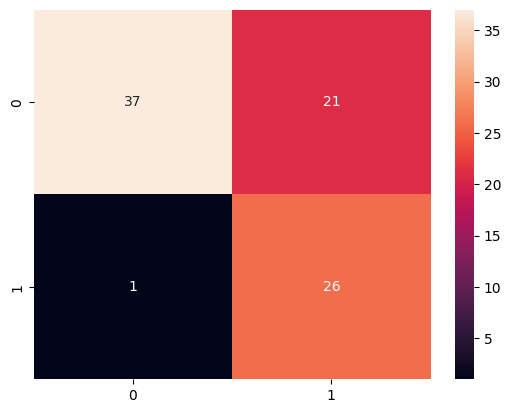

In [119]:
import seaborn as sns
values = multilabel_confusion_matrix(test_labels, binary_preds)
sns.heatmap(values[0],annot=True )

<Axes: >

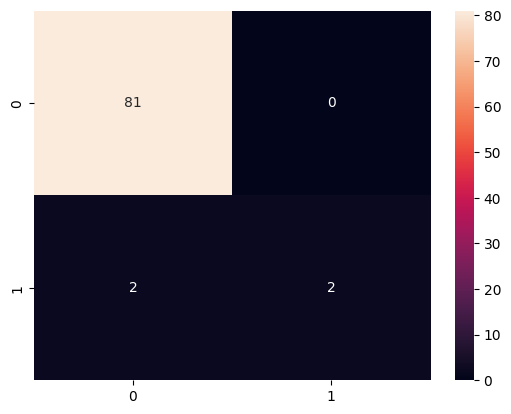

In [120]:
sns.heatmap(values[1],annot=True )

<Axes: >

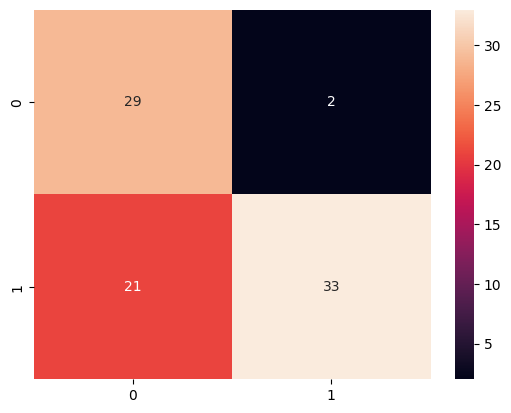

In [121]:
sns.heatmap(values[2],annot=True )

<Axes: >

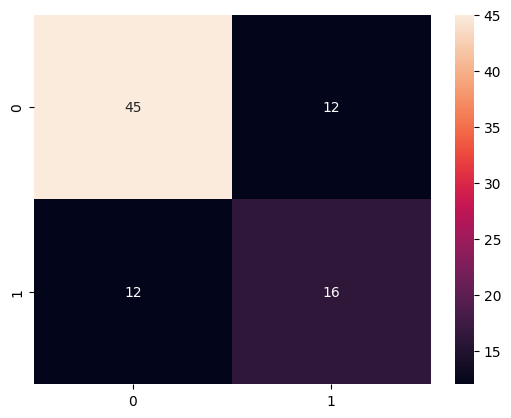

In [122]:
sns.heatmap(values[3],annot=True )

<Axes: >

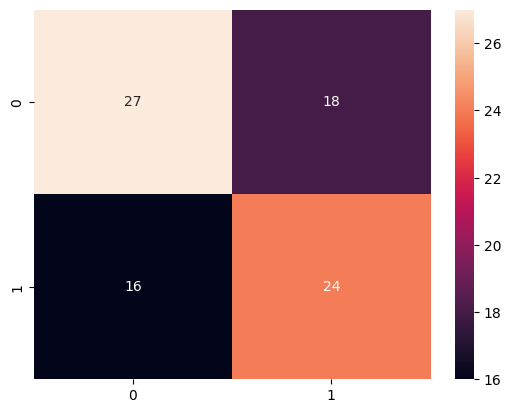

In [123]:
sns.heatmap(values[4],annot=True )

<Axes: >

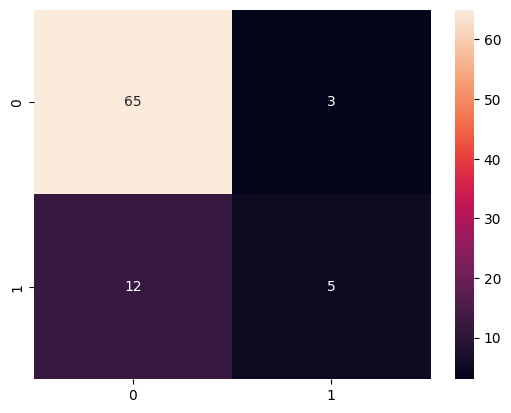

In [124]:
sns.heatmap(values[5],annot=True )

<Axes: >

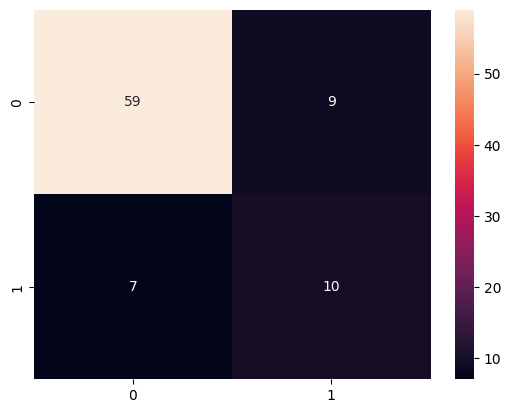

In [125]:
sns.heatmap(values[6],annot=True )

<Axes: >

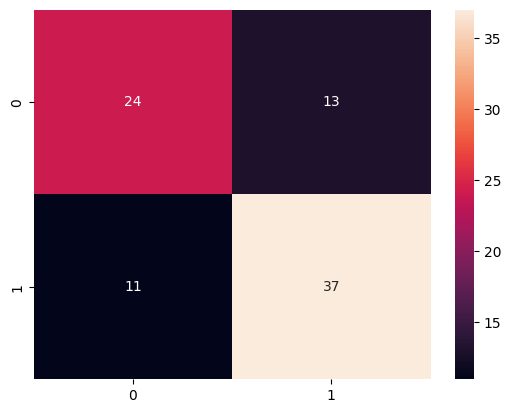

In [126]:
sns.heatmap(values[7],annot=True )

<Axes: >

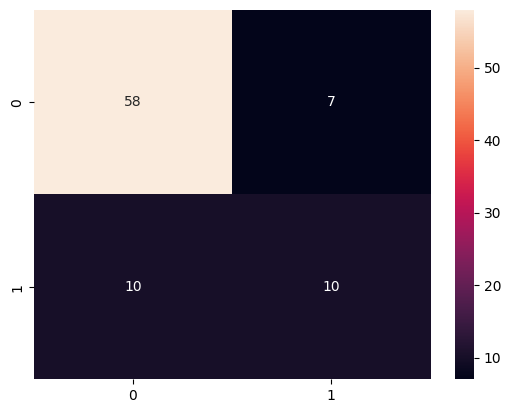

In [127]:
sns.heatmap(values[8],annot=True )